<a href="https://colab.research.google.com/github/KushanChamindu/Pump-it-Up-Data-Mining-the-Water-Table-Competition/blob/main/Pump_it_up_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [284]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [285]:
!pip install --upgrade category_encoders

In [286]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  KFold,cross_val_score
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

###Load data

In [287]:
drive_path_for_data = "/content/drive/MyDrive/Semester 7/ML/Machine learning project -water pump"

In [288]:
train_data_values = pd.read_csv(drive_path_for_data + "/training_set_values.csv")
train_data_labels = pd.read_csv(drive_path_for_data+ "/training_set_labels.csv")
test_data= pd.read_csv(drive_path_for_data+ "/test_set_values.csv")
test_data.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


###Data Observations

In [289]:
all_data = pd.concat([train_data_values,test_data])
display(all_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74250 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     74250 non-null  int64  
 1   amount_tsh             74250 non-null  float64
 2   date_recorded          74250 non-null  object 
 3   funder                 69746 non-null  object 
 4   gps_height             74250 non-null  int64  
 5   installer              69718 non-null  object 
 6   longitude              74250 non-null  float64
 7   latitude               74250 non-null  float64
 8   wpt_name               74250 non-null  object 
 9   num_private            74250 non-null  int64  
 10  basin                  74250 non-null  object 
 11  subvillage             73780 non-null  object 
 12  region                 74250 non-null  object 
 13  region_code            74250 non-null  int64  
 14  district_code          74250 non-null  int64  
 15  lg

None

In [290]:
# [print(n) for n in df.scheme_name.unique()]
# print("id \n",df.id.unique())
# print("amount_tsh\n",len(df.amount_tsh.unique()))
# print("date_recorded\n",df.date_recorded.unique())
# print("funder\n",len(df.funder.unique()))
# print("gps_height\n",(df.gps_height.unique()))
# print("installer\n",(df.installer.unique()))
# print("longitude\n",(df.longitude.unique()))
# print("latitude\n",(df.latitude.unique()))
# print("wpt_name\n",(df.wpt_name.unique()))
# print("num_private\n",(df.num_private.unique()))
# print("basin\n",df.basin.unique())
# print("subvillage\n",(df.subvillage.unique()))
# print("region\n",(df.region.unique()))
# print("region_code\n",len(df.region_code.unique()))
# print("district_code\n",len(df.district_code.unique()))
# print("lga\n",(df.lga.unique()))
# print("ward\n",(df.ward.unique()))
# print("population\n",(df.population.unique()))
# print("public_meeting\n",(df.public_meeting.unique()))
# print("recorded_by\n",df.recorded_by.unique())

# print("scheme_management \n",len(df.scheme_management.unique()))
# print("scheme_name\n",len(df.scheme_name.unique()))
# print("permit\n",len(df.permit.unique()))
# print("construction_year\n",df.construction_year.unique())
# print("extraction_type\n",(df.extraction_type.unique()))
# print("extraction_type_group\n",(df.extraction_type_group.unique()))
# print("extraction_type_class\n",len(df.extraction_type_class.unique()))
# print("management\n",(df.management.unique()))
# print("management_group\n",(df.management_group.unique()))
# print("payment\n",df.payment.unique())
# print("payment_type\n",df.payment_type.unique())
# print("water_quality\n",df.water_quality.unique())
# print("quality_group\n",df.quality_group.unique())
# print("quantity\n",df.quantity.unique())
# print("quantity_group\n",df.quantity_group.unique())
# print("source\n",df.source.unique())
# print("source_type\n",df.source_type.unique())
# print("source_class\n",df.source_class.unique())
print("waterpoint_type\n",all_data.waterpoint_type.unique())
print("waterpoint_type_group\n",all_data.waterpoint_type_group.unique())

waterpoint_type
 ['communal standpipe' 'communal standpipe multiple' 'hand pump' 'other'
 'improved spring' 'cattle trough' 'dam']
waterpoint_type_group
 ['communal standpipe' 'hand pump' 'other' 'improved spring'
 'cattle trough' 'dam']


### Imbalance check

In [291]:
train_data_labels["status_group"].value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

### Remove similar features

####water_point_type and waterpoint_type_group

In [292]:
all_data.waterpoint_type.value_counts()

communal standpipe             35628
hand pump                      21884
other                           8010
communal standpipe multiple     7611
improved spring                  959
cattle trough                    150
dam                                8
Name: waterpoint_type, dtype: int64

In [293]:
all_data.waterpoint_type_group.value_counts()

communal standpipe    43239
hand pump             21884
other                  8010
improved spring         959
cattle trough           150
dam                       8
Name: waterpoint_type_group, dtype: int64

In [294]:
print(all_data.groupby(['waterpoint_type','waterpoint_type_group']).count())

                                                      id  ...  source_class
waterpoint_type             waterpoint_type_group         ...              
cattle trough               cattle trough            150  ...           150
communal standpipe          communal standpipe     35628  ...         35628
communal standpipe multiple communal standpipe      7611  ...          7611
dam                         dam                        8  ...             8
hand pump                   hand pump              21884  ...         21884
improved spring             improved spring          959  ...           959
other                       other                   8010  ...          8010

[7 rows x 38 columns]


Both waterpoint_type & waterpoint_type_group similar and that was proved by above output(details are same in the both features). So we can keep more detailed feature and drop other. waterpoint_type_group should be dropped. 

####Quantity vs Quantity_group

In [295]:
all_data.quantity.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity, dtype: int64

In [296]:
all_data.quantity_group.value_counts()

enough          41522
insufficient    18896
dry              7782
seasonal         5075
unknown           975
Name: quantity_group, dtype: int64

In [297]:
print(all_data.groupby(['quantity','quantity_group']).count())

                                id  ...  waterpoint_type_group
quantity     quantity_group         ...                       
dry          dry              7782  ...                   7782
enough       enough          41522  ...                  41522
insufficient insufficient    18896  ...                  18896
seasonal     seasonal         5075  ...                   5075
unknown      unknown           975  ...                    975

[5 rows x 38 columns]


Both quantity & quantity_group similar and that was proved by above output(details are same in the both features). We can drop one of them.

####Water_quality & Quality_group

In [298]:
all_data.water_quality.value_counts()

soft                  63505
salty                  6082
unknown                2345
milky                  1005
coloured                623
salty abandoned         423
fluoride                244
fluoride abandoned       23
Name: water_quality, dtype: int64

In [299]:
all_data.quality_group.value_counts()

good        63505
salty        6505
unknown      2345
milky        1005
colored       623
fluoride      267
Name: quality_group, dtype: int64

In [300]:
print(all_data.groupby(['water_quality','quality_group']).count())

                                     id  ...  waterpoint_type_group
water_quality      quality_group         ...                       
coloured           colored          623  ...                    623
fluoride           fluoride         244  ...                    244
fluoride abandoned fluoride          23  ...                     23
milky              milky           1005  ...                   1005
salty              salty           6082  ...                   6082
salty abandoned    salty            423  ...                    423
soft               good           63505  ...                  63505
unknown            unknown         2345  ...                   2345

[8 rows x 38 columns]


Both water_quality & quality_group similar and that was proved by above output(details are same in the both features). So we can keep more detailed feature and drop other. quality_group should be droped.

####Payment & Payment_type

In [301]:
all_data.payment.value_counts()

never pay                31712
pay per bucket           11266
pay monthly              10397
unknown                  10149
pay when scheme fails     4842
pay annually              4570
other                     1314
Name: payment, dtype: int64

In [302]:
all_data.payment_type.value_counts()

never pay     31712
per bucket    11266
monthly       10397
unknown       10149
on failure     4842
annually       4570
other          1314
Name: payment_type, dtype: int64

In [303]:
print(all_data.groupby(['payment','payment_type']).count())

                                       id  ...  waterpoint_type_group
payment               payment_type         ...                       
never pay             never pay     31712  ...                  31712
other                 other          1314  ...                   1314
pay annually          annually       4570  ...                   4570
pay monthly           monthly       10397  ...                  10397
pay per bucket        per bucket    11266  ...                  11266
pay when scheme fails on failure     4842  ...                   4842
unknown               unknown       10149  ...                  10149

[7 rows x 38 columns]


Both payment & payment_type similar and that was proved by above output(details are same in the both features). So we can drop one of them.

####Scheme_management, Management & Management_group

In [304]:
print("NaN value count:", all_data.scheme_management.isna().sum())
all_data.scheme_management.value_counts()

NaN value count: 4846


VWC                 45917
WUG                  6496
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [305]:
all_data.management.value_counts()

vwc                 50624
wug                  8108
water board          3688
wua                  3118
private operator     2504
parastatal           2229
water authority      1123
other                1083
company               859
unknown               683
other - school        126
trust                 105
Name: management, dtype: int64

Both scheme_management & management similar and that was proved by above output(details are same in the both features). So we can keep more detailed feature and drop other. scheme_management feature has more nan data. So we can drop it.

In [306]:
all_data.management_group.value_counts()

user-group    65538
commercial     4591
parastatal     2229
other          1209
unknown         683
Name: management_group, dtype: int64

In [307]:
print(all_data.groupby(['management','management_group']).count())

                                      id  ...  waterpoint_type_group
management       management_group         ...                       
company          commercial          859  ...                    859
other            other              1083  ...                   1083
other - school   other               126  ...                    126
parastatal       parastatal         2229  ...                   2229
private operator commercial         2504  ...                   2504
trust            commercial          105  ...                    105
unknown          unknown             683  ...                    683
vwc              user-group        50624  ...                  50624
water authority  commercial         1123  ...                   1123
water board      user-group         3688  ...                   3688
wua              user-group         3118  ...                   3118
wug              user-group         8108  ...                   8108

[12 rows x 38 columns]


According to domain knowledge, we can consider managment and managment group has same details. So we can keep detailed feature and drop less detailed feature. So management_group drop

####Extraction_type, extraction_type_group & extraction_type_class

In [308]:
all_data.extraction_type.value_counts()

gravity                      33263
nira/tanira                  10205
other                         8102
submersible                   5982
swn 80                        4588
mono                          3628
india mark ii                 3029
afridev                       2208
ksb                           1790
other - rope pump              572
other - swn 81                 284
windmill                       152
india mark iii                 135
cemo                           108
other - play pump              101
walimi                          60
climax                          41
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64

In [309]:
all_data.extraction_type_group.value_counts()

gravity            33263
nira/tanira        10205
other               8102
submersible         7772
swn 80              4588
mono                3628
india mark ii       3029
afridev             2208
rope pump            572
other handpump       447
wind-powered         152
other motorpump      149
india mark iii       135
Name: extraction_type_group, dtype: int64

Both extraction_type & extraction_type_group has same details but in extraction_type some classes have very low values compared to the total number of data. That classes has not enough data.So extraction_type should be dropped.

In [310]:
all_data.extraction_type_class.value_counts()

gravity         33263
handpump        20612
other            8102
submersible      7772
motorpump        3777
rope pump         572
wind-powered      152
Name: extraction_type_class, dtype: int64

In [311]:
print(all_data.groupby(['extraction_type_group', 'extraction_type_class']).count())

                                                id  ...  waterpoint_type_group
extraction_type_group extraction_type_class         ...                       
afridev               handpump                2208  ...                   2208
gravity               gravity                33263  ...                  33263
india mark ii         handpump                3029  ...                   3029
india mark iii        handpump                 135  ...                    135
mono                  motorpump               3628  ...                   3628
nira/tanira           handpump               10205  ...                  10205
other                 other                   8102  ...                   8102
other handpump        handpump                 447  ...                    447
other motorpump       motorpump                149  ...                    149
rope pump             rope pump                572  ...                    572
submersible           submersible             7772  

Both extraction_type_group & extraction_type_class similar and that was proved by above output(details are same in the both features). So we can keep more detailed feature and drop other. extraction_type_class should drop.

####Source, Source_type & Source_class columns

In [312]:
all_data.source.value_counts()

spring                  21216
shallow well            21140
machine dbh             13822
river                   11964
rainwater harvesting     2863
hand dtw                 1108
lake                      950
dam                       840
other                     261
unknown                    86
Name: source, dtype: int64

In [313]:
all_data.source_type.value_counts()

spring                  21216
shallow well            21140
borehole                14930
river/lake              12914
rainwater harvesting     2863
dam                       840
other                     347
Name: source_type, dtype: int64

In [314]:
all_data.source_class.value_counts()

groundwater    57286
surface        16617
unknown          347
Name: source_class, dtype: int64

In [315]:
print(all_data.groupby(['source','source_type', 'source_class']).count())

                                                           id  ...  waterpoint_type_group
source               source_type          source_class         ...                       
dam                  dam                  surface         840  ...                    840
hand dtw             borehole             groundwater    1108  ...                   1108
lake                 river/lake           surface         950  ...                    950
machine dbh          borehole             groundwater   13822  ...                  13822
other                other                unknown         261  ...                    261
rainwater harvesting rainwater harvesting surface        2863  ...                   2863
river                river/lake           surface       11964  ...                  11964
shallow well         shallow well         groundwater   21140  ...                  21140
spring               spring               groundwater   21216  ...                  21216
unknown   

Both source, source_type & source_class similar and that was proved by above output(details are same in the all mentioned features). So we can keep more detailed feature and drop other. source_type and source_class should drop.

##Preprocessing

#### Clean data

In [316]:
def clean(df):
    # drop above found features
    df.drop(columns=['source_class','source_type','management_group','scheme_management','quantity_group','quality_group','payment_type','extraction_type_class','extraction_type', 'waterpoint_type_group'],inplace=True )
    typo_correction(df)
    return df

In [317]:
# for item in all_data.installer.unique():
#   print(item)
def typo_correction(df):
  df['installer'].replace(to_replace = ('villigers', 'villager', 'Villagers', 'Villa', 'Village', 'Villi', 
                                        'Village Council','Village Counil', 'Villages', 'Vill', 'Village community', 
                                        'Villaers', 'Village Community', 'Villag','Villege Council', 'Village council',
                                        'Village  Council','Villagerd', 'Villager', 'Village Technician',
                                        'Village Office','Village community members'),
                                          value ='villagers' , inplace=True)
  df['installer'].replace(to_replace =('Commu','Communit','commu','COMMU', 'COMMUNITY') ,
                                          value ='Community' , inplace=True)

  df['installer'].replace(to_replace = ('GOVERNMENT', 'GOVER', 'GOVERNME', 'GOVERM','GOVERN','Gover','Gove',
                                        'Governme','Governmen' ) ,value ='Government' , inplace=True)

  df['installer'].replace(to_replace = 'Hesawa' ,value ='HESAWA' , inplace=True)
  df['installer'].replace(to_replace = ('District Water Department', 'District water depar','Distric Water Department'),
                        value ='District water department' , inplace=True)

  df['installer'].replace(to_replace = ('FinW','Fini water','FINI WATER'), value ='Fini Water' , inplace=True)
  df['installer'].replace(to_replace = 'JAICA', value ='Jaica' , inplace=True)

  df['installer'].replace(to_replace = ('COUN', 'District COUNCIL', 'DISTRICT COUNCIL','District Counci', 
                                        'District Council','Council','Counc','District  Council','Distri'),
                                      value ='District council' , inplace=True)

  df['installer'].replace(to_replace = ('RC CHURCH', 'RC Churc', 'RC','RC Ch','RC C', 'RC CH','RC church', 
                                        'RC CATHORIC',) , value ='RC Church' , inplace=True)

  df['installer'].replace(to_replace = ('Central Government','Tanzania Government',
                                        'central government','Cental Government', 'Cebtral Government', 
                                        'Tanzanian Government','Tanzania government', 'Centra Government' ,
                                        'CENTRAL GOVERNMENT', 'TANZANIAN GOVERNMENT','Central govt', 'Centr', 
                                        'Centra govt') , value ='Central government' , inplace=True)

  df['installer'].replace(to_replace = ('World vision', 'World Division','World Vision'),
                                          value ='world vision' , inplace=True)

  df['installer'].replace(to_replace = ('Unisef','UNICEF'),value ='Unicef' , inplace=True)
  df['installer'].replace(to_replace = 'DANID', value ='DANIDA' , inplace=True)


  df['installer'].replace(to_replace = ('Colonial Government') , value ='Colonial government' , inplace=True)
  df['installer'].replace(to_replace = ('Government of Misri') , value ='Misri Government' , inplace=True)
  df['installer'].replace(to_replace = ('Italy government') , value ='Italian government' , inplace=True)
  df['installer'].replace(to_replace = ('British colonial government') , value ='British government' , inplace=True)
  df['installer'].replace(to_replace = ('Concern /government') , value ='Concern/Government' , inplace=True)
  df['installer'].replace(to_replace = ('Village Government') , value ='Village government' , inplace=True)
  df['installer'].replace(to_replace = ('Government and Community') , value ='Government /Community' , inplace=True)
  df['installer'].replace(to_replace = ('Cetral government /RC') , value ='RC church/Central Gover' , inplace=True)
  df['installer'].replace(to_replace = ('Government /TCRS','Government/TCRS') , value ='TCRS /Government' , inplace=True)
  df['installer'].replace(to_replace = ('ADRA /Government') , value ='ADRA/Government' , inplace=True)
  return df
  


In [318]:
# clean(all_data)
# len(all_data.installer.unique())
# all_data.installer.value_counts().head(20)

#### Encode

1. "amount_tsh - numarical - no nan -102 unique data"
2. "funder categorical"
3. "gps_height 2456 unique values - numerical data"
4. "installer  2411 string"
5. "longitude 71870 unique values numerical"
6. "latitude  71869 unique values numerical"
7. "basin - smalll number of nunique values strings"
8. "region - smalll number of nunique values strings"
9. "district_code-  smalll number of nunique values- numerical data"
10. "lga - 125 number of unique values- strings"
11. "ward  2098 unique values - string"
12. "population 1128 unique values - numerical"
13. "public_meeting - true false nan"
14. "permit - true false nan"
15. "construction_year - small number of unique values - numerical"
16. "extraction_type_group - string smalll number of unique values"
17. "management string smalll number of unique values"
18. "payment - string smalll number of unique values"
19. "water_quality- string smalll number of unique values"             
20. "quantity         string smalll number of unique values"      
21. "source            string smalll number of unique values"          
22. "waterpoint_type     string smalll number of unique values"     

**Removed features in preprocessing step**

1. "source_type       string smalll number of unique values"     
2. "source_class      string smalll number of unique values"    
3. "management_group string smalll number of unique values" 
4. "scheme_management  - strings small number of uniques" 
5. "quantity_group    string smalll number of unique values"  
6. "quality_group   string smalll number of unique values"
7. "payment_type - string smalll number of unique values"
8. "extraction_type_class - string smalll number of unique values"
9. "extraction_type - string smalll number of unique values"
10. "waterpoint_type_group  string smalll number of unique values"
-------
11. "recorded_by - only have obe value for all"
12. "wpt_name - String 45684 unique values"
13. "scheme_name  strings small number of uniques"
14. "region_code -  smalll number of nunique values- numerical data"
15. "num_private  numerical data- have small number of unique values"
16. "date_recorded - dates 369 uniques"
17. "subvillage - 21426 unique values strings"


The numeric features : id, amount_tsh, gps_height, longitude, latitude, num_private, population

* Categorical :
     date_recorded, funder, installer, wpt_name, basin, subvillage, region, region_code, district_code, lga, 
     ward, public_meeting, recorded_by, scheme_management, scheme_name, permit, construction_year, extraction_type,
     extraction_type_group, extraction_type_class, management, management_group, payment, payment_type, water_quality,
     quality_group, quantity, quantity_group, source, source_type, source_class, waterpoint_type, waterpoint_type_group

* The numeric features : id, amount_tsh, gps_height, longitude, latitude, num_private, population - These numeric features are already encoded correctly

* Features with null: funder, installer, subvillage, public_meeting, scheme_management, scheme_name, permit

In [319]:
#list down unordered categorical features
features_nom = ["date_recorded","funder", "installer","wpt_name","basin","subvillage","region","region_code","district_code", "lga", "ward", "public_meeting", 
                "recorded_by","scheme_name","permit", "construction_year", "extraction_type_group", "management","payment", "water_quality", 
                "quantity", "source","waterpoint_type"]

numerical_features = ["amount_tsh","gps_height","longitude", "latitude","population", "num_private"]
ordered_levels = {             # list down un ordered categorical coloumn and assign categories
}

# Add a None level for missing values
ordered_levels = {key: ["None"] + value for key, value in ordered_levels.items()}


def encode(df):   
    # Nominal categories
    for name in features_nom:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories and df[name].isnull().sum() !=0:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in ordered_levels.items():
        df[name] = df[name].astype(CategoricalDtype(levels,
                                                    ordered=True))
    return df

In [320]:
# encode(df)
# display(df.info())

#### Impute

In [321]:
def impute(df):
    # for name in df.select_dtypes("number"):
    #     df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        if "None" in df[name].cat.categories:
            df[name] = df[name].fillna("None")
    # for name in df.select_dtypes("object"):
    #     df[name] = df[name].fillna("None")
    return df

#### Load Data

In [322]:
def load_data():
    # Read data
    drive_path_for_data = "/content/drive/MyDrive/Semester 7/ML/Machine learning project -water pump"
    train_data_values = pd.read_csv(drive_path_for_data + "/training_set_values.csv")
    train_data_labels = pd.read_csv(drive_path_for_data+ "/training_set_labels.csv")
    test_data= pd.read_csv(drive_path_for_data+ "/test_set_values.csv")

    # df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
    # df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
    train_data_values=train_data_values.set_index("id")
    test_data=test_data.set_index("id")
    train_data_labels=train_data_labels.set_index("id")

    train_data = train_data_values.merge(train_data_labels, left_index=True, right_index=True)

    # print(train_data.info())
    # Merge the splits so we can process them together
    df = pd.concat([train_data, test_data])
    # Preprocessing
    df = clean(df)
    df = encode(df)
    df = impute(df)
    # Reform splits
    df_train = df.loc[train_data.index, :]
    df_test = df.loc[test_data.index, :]
    return df_train, df_test

In [323]:
train_data,test_data = load_data()

#### Unwanted feature detection

##### `wpt_name` check

In [324]:
train_data.wpt_name.value_counts()

none                 3563
Shuleni              1748
Zahanati              830
Msikitini             535
Kanisani              323
                     ... 
Kwa Mkanula             0
Kwa Mkange              0
Kwa Mkambati            0
Kwa Mkama Mbogola       0
21                      0
Name: wpt_name, Length: 45684, dtype: int64

##### `scheme_name` check

In [325]:
train_data.scheme_name.value_counts()

None                                         28810
K                                              682
Borehole                                       546
Chalinze wate                                  405
M                                              400
                                             ...  
makanj                                           0
Badimka                                          0
Gwarama point source sources water supply        0
Gwarama point sources water supply               0
Segese Pipe scheme                               0
Name: scheme_name, Length: 2868, dtype: int64

We can drop this two columns because `wpt_name` has lots of unique valus so it does not has useful details for classification. `scheme_name` has lots of none values.

##### `region` and `region_code` comparison

When we consider `region` and `region_code` we can remove more detailed feature because of the these both features has same informations. So we keep `region` and drop `region_code`.

##### `amount_tsh` check

In [326]:
train_data.amount_tsh.value_counts()

0.0         41639
500.0        3102
50.0         2472
1000.0       1488
20.0         1463
            ...  
8500.0          1
6300.0          1
220.0           1
138000.0        1
12.0            1
Name: amount_tsh, Length: 98, dtype: int64

In [327]:
train_data.loc[train_data['amount_tsh']==0.0].groupby('status_group').count().amount_tsh

status_group
functional                 19706
functional needs repair     3048
non functional             18885
Name: amount_tsh, dtype: int64

In here `amount_tsh` feature is not usefull because, more than 70% data has 0.0 for `amount_tsh`. So we can drop `amount_tsh`.

##### `date_recorded` check

`date_recorded` has no information with wells. Because almost all infortion of `data_recorded` lies on the 2011-2013 time period.

##### `num_private` check

In [328]:
train_data.num_private.value_counts()

0      58643
6         81
1         73
5         46
8         46
       ...  
180        1
213        1
23         1
55         1
94         1
Name: num_private, Length: 65, dtype: int64

Almost all values of the in this feature is 0. So we drop `num_private`.

##### `subvillage` check

In [329]:
train_data.subvillage.value_counts()

Madukani             508
Shuleni              506
Majengo              502
Kati                 373
None                 371
                    ... 
Ilookisiti             0
Mwangwika              0
Mwanholo               0
Ilolangulu Center      0
Mangomela              0
Name: subvillage, Length: 21426, dtype: int64

We also can remove this feature because this feature has lots of unique values and region also has this informations.

##### `recorded_by` Check

In [330]:
train_data.recorded_by.unique()

['GeoData Consultants Ltd']
Categories (1, object): ['GeoData Consultants Ltd']

This has one values. So we drop `recorded_by` feature.

##### Drop unwanted features

In [331]:
## droped useless values.
all_data = pd.concat([train_data, test_data])
all_data.drop(columns=['wpt_name','scheme_name','region_code', 'amount_tsh','date_recorded','num_private', 'subvillage', 'recorded_by'],inplace=True )
train_data = all_data.loc[train_data.index, :]
test_data = all_data.loc[test_data.index, :]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   funder                 59400 non-null  category
 1   gps_height             59400 non-null  int64   
 2   installer              59400 non-null  category
 3   longitude              59400 non-null  float64 
 4   latitude               59400 non-null  float64 
 5   basin                  59400 non-null  category
 6   region                 59400 non-null  category
 7   district_code          59400 non-null  category
 8   lga                    59400 non-null  category
 9   ward                   59400 non-null  category
 10  population             59400 non-null  int64   
 11  public_meeting         59400 non-null  category
 12  permit                 59400 non-null  category
 13  construction_year      59400 non-null  category
 14  extraction_type_group  59400 non-n

##### `installer` and `funder` categories reduce

In [332]:
train_data.installer.replace(to_replace = '0', value ='None' , inplace=True)  ## replace "0" with None
test_data.installer.replace(to_replace = '0', value ='None' , inplace=True) 
train_data.installer.replace(to_replace = 'Unknown', value ='None' , inplace=True)  ## replace "0" with None
test_data.installer.replace(to_replace = 'Unknown', value ='None' , inplace=True) 

In [333]:
populated_categories_installer = ['DWE','None','Government','Community','DANIDA','HESAWA','RWE','District council', 'Central government',
         'KKKT','TCRS', 'world vision', 'CES', 'Fini Water', 'RC Church','villagers','LGA']
train_data.loc[~train_data["installer"].isin(populated_categories_installer), "installer"] = "Others"
test_data.loc[~test_data["installer"].isin(populated_categories_installer), "installer"] = "Others"
train_data.installer = train_data.installer.cat.remove_unused_categories()
test_data.installer = test_data.installer.cat.remove_unused_categories()
print(train_data.installer.value_counts())

Others                21983
DWE                   17402
None                   4435
Government             2660
Community              1674
DANIDA                 1602
HESAWA                 1379
RWE                    1206
District council       1179
Central government     1114
KKKT                    898
TCRS                    707
world vision            681
CES                     610
Fini Water              593
RC Church               461
LGA                     408
villagers               408
Name: installer, dtype: int64


We change the "0", "Unknown" values with the "None". In impute function its automatically replace `nan` with the "None". Then we keep categories which has more than 400 data rows and drop others.

In [334]:
train_data.funder.replace(to_replace = '0', value ='None' , inplace=True)  ## replace "0" with None
test_data.funder.replace(to_replace = '0', value ='None' , inplace=True) 
train_data.funder.replace(to_replace = 'Unknown', value ='None' , inplace=True)  ## replace "0" with None
test_data.funder.replace(to_replace = 'Unknown', value ='None' , inplace=True) 

In [335]:
populated_categories_funder = ['Government Of Tanzania','Unknown','Danida','Hesawa','Rwssp','World Bank','Kkkt', 'World Vision',
         'Unicef','Tasaf','District Council', 'Dhv', 'Private Individual', 'Dwsp','Norad','Germany Republi',
         'Tcrs','Ministry Of Water','Water','Dwe']
train_data.loc[~train_data["funder"].isin(populated_categories_funder), "funder"] = "Others"
test_data.loc[~test_data["funder"].isin(populated_categories_funder), "funder"] = "Others"
train_data.funder = train_data.funder.cat.remove_unused_categories()
test_data.funder = test_data.funder.cat.remove_unused_categories()
print(train_data.funder.value_counts())

Others                    30867
Government Of Tanzania     9084
Danida                     3114
Hesawa                     2202
Rwssp                      1374
World Bank                 1349
Kkkt                       1287
World Vision               1246
Unicef                     1057
Tasaf                       877
District Council            843
Dhv                         829
Private Individual          826
Dwsp                        811
Norad                       765
Germany Republi             610
Tcrs                        602
Ministry Of Water           590
Water                       583
Dwe                         484
Name: funder, dtype: int64


We change the "0", "Unknown" values with the "None". In impute function its automatically replace nan with the "None". Then we keep first 20 categories  and drop others.

##### `longitute` and `latitute` "0" value handle

In [336]:
train_data.longitude.value_counts()

0.000000     1812
37.540901       2
33.010510       2
39.093484       2
32.972719       2
             ... 
37.579803       1
33.196490       1
34.017119       1
33.788326       1
30.163579       1
Name: longitude, Length: 57516, dtype: int64

In [337]:
train_data.loc[train_data.longitude!=0].longitude.describe()

count    57588.000000
mean        35.149669
std          2.607428
min         29.607122
25%         33.285100
50%         35.005943
75%         37.233712
max         40.345193
Name: longitude, dtype: float64

In [338]:
train_data.longitude.replace(to_replace = 0 , value =35.15, inplace=True)
test_data.longitude.replace(to_replace = 0 , value =35.15, inplace=True)

There are 1812, 0 rows on longitude. We can think it as unknown longitude and obviously they are outliers. So we replace them with mean.

In [339]:
train_data.latitude.value_counts()

-2.000000e-08    1812
-6.985842e+00       2
-3.797579e+00       2
-6.981884e+00       2
-7.104625e+00       2
                 ... 
-5.726001e+00       1
-9.646831e+00       1
-8.124530e+00       1
-2.535985e+00       1
-2.598965e+00       1
Name: latitude, Length: 57517, dtype: int64

latitue is safe beacuse it doesn't have 0 values.

##### `permit` and `public_meetinng` replace missing value with most common value

In [340]:
train_data.permit.unique()

[False, True, 'None']
Categories (3, object): [False, True, 'None']

In [341]:
train_data.permit.value_counts()

True     38852
False    17492
None      3056
Name: permit, dtype: int64

In [342]:
train_data.permit.replace(to_replace = "None" , value = True, inplace=True)
test_data.permit.replace(to_replace = "None" , value = True, inplace=True)
train_data.permit.value_counts()

True     41908
False    17492
Name: permit, dtype: int64

In [343]:
print(train_data.public_meeting.unique())
print(train_data.public_meeting.value_counts())

[True, 'None', False]
Categories (3, object): [True, 'None', False]
True     51011
False     5055
None      3334
Name: public_meeting, dtype: int64


In [344]:
train_data.public_meeting.replace(to_replace = "None" , value = True, inplace=True)
test_data.public_meeting.replace(to_replace = "None" , value = True, inplace=True)
train_data.public_meeting.value_counts()

True     54345
False     5055
Name: public_meeting, dtype: int64

##### `population` '0' value handle

In [345]:
print(train_data.population.head())
print("\n")
print(train_data.loc[train_data.population!=0].population.describe())

id
69572    109
8776     280
34310    250
67743     58
19728      0
Name: population, dtype: int64


count    38019.000000
mean       281.087167
std        564.687660
min          1.000000
25%         40.000000
50%        150.000000
75%        324.000000
max      30500.000000
Name: population, dtype: float64


In [346]:
train_data.population.replace(to_replace = 0 , value = 281, inplace=True)
test_data.population.replace(to_replace = 0 , value = 281, inplace=True)
train_data.population.head(10)

id
69572    109
8776     280
34310    250
67743     58
19728    281
9944       1
19816    281
54551    281
53934    281
46144    281
Name: population, dtype: int64

## Feature Engineering

#### Mutual infomation check

In [347]:
def make_mi_scores(X, y, is_one_hot_encode):
    X = X.copy()
    if is_one_hot_encode:
        for colname in X.select_dtypes(["category", "object"]):
            X_dummies = pd.get_dummies(X[colname], drop_first=False,prefix = colname)
            X = X.join(X_dummies)
            X = X.drop(colname,1)
    else:
        for colname in X.select_dtypes(["object", "category"]):
            X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

ward                     0.180663
quantity                 0.107691
lga                      0.088305
longitude                0.066381
waterpoint_type          0.066140
extraction_type_group    0.061365
latitude                 0.060861
region                   0.042456
construction_year        0.034043
payment                  0.032248
funder                   0.029547
installer                0.029194
source                   0.025937
population               0.021359
water_quality            0.019420
basin                    0.019118
management               0.017706
gps_height               0.016582
district_code            0.015665
permit                   0.005748
public_meeting           0.000000
Name: MI Scores, dtype: float64


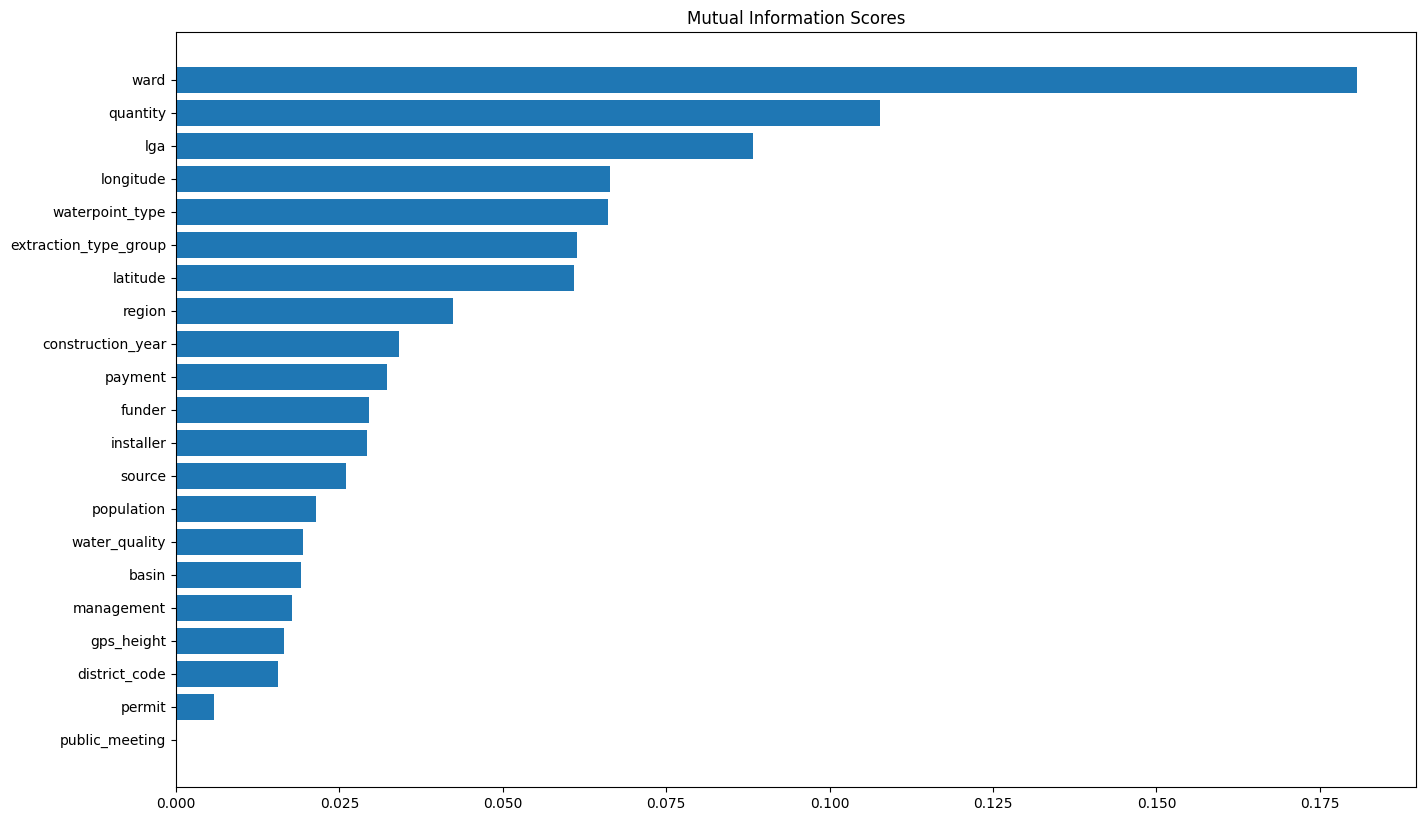

In [348]:
X_train = train_data.copy()
y_train = X_train.pop("status_group")
mi_scores = make_mi_scores(X_train.copy(), y_train, False)
print(mi_scores)

plt.figure(dpi=100, figsize=(16, 10))
plot_mi_scores(mi_scores)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


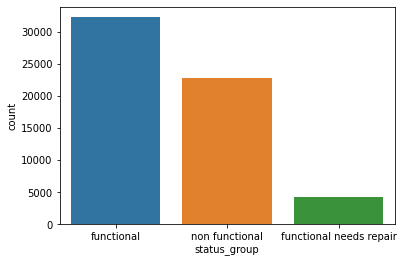

In [349]:
sns.countplot(train_data['status_group'])

'funtional' wells amount is near 30k but 'non-functional' has only 20k and 'functional nedd repair' has near 5k data.

#### `construction_year` Binning to decade

In [350]:
def construction_year_binning(df):
  df['construction_decade'] = df['construction_year']

  df['construction_decade'].replace(to_replace = (1960,1961,1962,1963,1964,1965,1966,1967,1968,1969),
                          value ='60s' , inplace=True)
  df['construction_decade'].replace(to_replace = (1970,1971,1972,1973,1974,1975,1976,1977,1978,1979),
                          value ='70s' , inplace=True)
  df['construction_decade'].replace(to_replace = (1980,1981,1982,1983,1984,1985,1986,1987,1988,1989),
                          value ='80s' , inplace=True)
  df['construction_decade'].replace(to_replace = (1990,1991,1992,1993,1994,1995,1996,1997,1998,1999),
                          value ='90s' , inplace=True)
  df['construction_decade'].replace(to_replace = (2000,2001,2002,2003,2004,2005,2006,2007,2008,2009),
                          value ='00s' , inplace=True)
  df['construction_decade'].replace(to_replace = (2010,2011,2012,2013),
                          value ='10s' , inplace=True)
  df.drop(columns=['construction_year'],inplace=True )
  return df
train_data = construction_year_binning(train_data)
test_data = construction_year_binning(test_data)

In [351]:
train_data.construction_decade.unique()

['90s', '10s', '00s', '80s', 0, '70s', '60s']
Categories (7, object): ['90s', '10s', '00s', '80s', 0, '70s', '60s']

#### `status_group` binning

In [352]:
target_status_group = {'functional':0,
                       'functional needs repair': 1,
                       'non functional': 2
} 
train_data['status_group'] = train_data['status_group'].replace(target_status_group)

#### Score check

In [353]:
def score_dataset(X_train, y, model= RandomForestClassifier(criterion='gini', 
                             n_estimators=100,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1, verbose=2, class_weight = 'balanced')):

    for colname in X_train.select_dtypes(["category", "object"]):
        X_dummies = pd.get_dummies(X_train[colname], drop_first=False,prefix = colname)
        X_train = X_train.join(X_dummies)
        X_train = X_train.drop(colname,1)

    for colname in y.select_dtypes(["category", "object"]):
        dummies = pd.get_dummies(y[colname], prefix=colname, drop_first=False) # One hot encoding
        y = y.join(dummies)
        y = y.drop(colname, 1)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)

    # predictions on test set
    y_pred_test = model.predict(X_test)  
    # to print the results in good way
    print("Accuracy:"); print("="*len("Accuracy:"))
    print(f"TRAIN: {accuracy_score(y_train, y_pred)}")
    print(f"TEST: {accuracy_score(y_test, y_pred_test)}")

    print("\nBalanced Accuracy:"); print("="*len("Balanced Accuracy:"))
    print(f"TRAIN: {balanced_accuracy_score(y_train, y_pred)}")
    print(f"TEST: {balanced_accuracy_score(y_test, y_pred_test)}")
    # score = cross_val_score(
    #     model, X_train, y, cv=2, scoring="neg_mean_squared_log_error",
    # )
    # score = -1 * score.mean()
    # score = np.sqrt(score)
    return model

In [354]:
# features = ["amount_tsh","source"]
# display(train_data.head(10))
X = train_data.copy()
y = train_data[["status_group"]].copy()
X.pop('status_group')
# score_dataset(X.copy(), y.copy())
train_data.status_group.head()

id
69572    0
8776     0
34310    0
67743    2
19728    0
Name: status_group, dtype: int64

In [355]:
# for i in train_data.gps_height.value_counts().head(200): print(i)
# plt.figure(1, figsize=(20,60))
# train_data.loc[train_data['gps_height']!=0].gps_height.plot(kind='bar')

#### Clutering longitute and latitude

In [356]:
def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
#     print(X_scaled)
    X_new = X.loc[:, features]
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new, kmeans


def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [357]:
def cluster_from_lon_lat(X_train_test):
    cluster_features = ["longitude", "latitude"]
    X_clustered, kmeans_feature_engineering = cluster_labels(X_train_test.copy(), cluster_features,12)
    # print(X_clustered.head())
    sns.relplot(
        x="longitude", y="latitude", hue="Cluster", data=X_clustered, height=5
    );
#     X_clustered_data = X_train.copy()
    X_train_test['long_lat'] = X_clustered.Cluster
    X_train_test['long_lat'] = X_train_test['long_lat'].astype("category")
    return X_train_test

In [358]:
# all_data = pd.concat([train_data, test_data])
# cluster_from_lon_lat(all_data)
# train_data = all_data.loc[train_data.index, :]
# train_data.status_group= train_data.status_group.astype("int64")
# test_data = all_data.loc[test_data.index, :]

In [359]:
train_data_dummy = train_data.copy()
test_data_dummy = test_data.copy()
# train_data_dummy.drop(columns=["longitude", "latitude"], inplace=True)
# test_data_dummy.drop(columns=["longitude", "latitude"], inplace=True)

In [360]:
X = train_data_dummy.copy()
y = train_data_dummy[["status_group"]].copy()
X.pop('status_group')
# score_dataset(X.copy(), y.copy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.0s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   56.8s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s


Accuracy:
TRAIN: 0.8946127946127946
TEST: 0.7835016835016835

Balanced Accuracy:
TRAIN: 0.9091153626876384
TEST: 0.723813505130083


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=2,
                       warm_start=False)

In [361]:
train_data_dummy

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,construction_decade
id,,,,,,,,,,,,,,,,,,,,,,
69572,Others,1390,Others,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,0,90s
8776,Others,1399,Others,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,0,10s
34310,Others,686,world vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,0,00s
67743,Unicef,263,Others,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,2,80s
19728,Others,0,Others,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,Germany Republi,1210,CES,37.169807,-3.253847,Pangani,Kilimanjaro,5,Hai,Masama Magharibi,125,True,True,gravity,water board,pay per bucket,soft,enough,spring,communal standpipe,0,90s
27263,Others,1212,Others,35.249991,-9.070629,Rufiji,Iringa,4,Njombe,Ikondo,56,True,True,gravity,vwc,pay annually,soft,enough,river,communal standpipe,0,90s
37057,Others,0,None,34.017087,-8.750434,Rufiji,Mbeya,7,Mbarali,Chimala,281,True,False,swn 80,vwc,pay monthly,fluoride,enough,machine dbh,hand pump,0,0


#### PCA

In [362]:
def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

                 PC1       PC2
gps_height -0.707107  0.707107
population  0.707107  0.707107


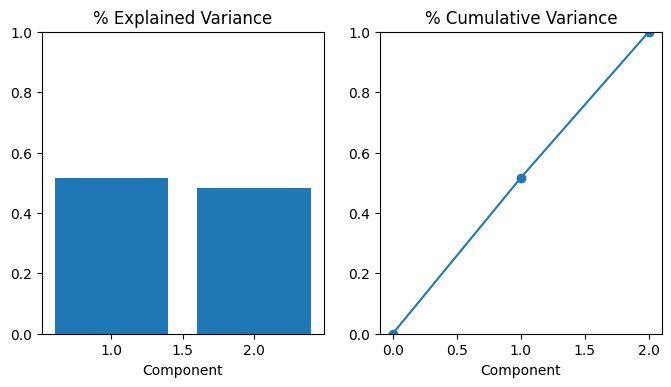

In [363]:
features_for_PCA = [
        "gps_height",
        "population"
    ]
all_data = pd.concat([train_data_dummy, test_data_dummy])

pca, all_data_pca, loadings= apply_pca(all_data[features_for_PCA])
print(loadings)
# Look at explained variance
plot_variance(pca);

train_pca = all_data_pca.loc[train_data.index, :]

train_data = all_data.loc[train_data.index, :]
train_data.status_group= train_data.status_group.astype("int64")
test_data = all_data.loc[test_data.index, :]

In [364]:
make_mi_scores(train_pca,train_data['status_group'],True)

PC2    0.003502
PC1    0.001901
Name: MI Scores, dtype: float64

According to the above output, we can consider `gps_height` and `population` features has significant relation ship between them. And also according to the mu_scores, features' PCA component shows considerable relation with the `status_group` . So, we use these PCA component as features in the dataset. 

In [365]:
def add_pca_component_to_dataset(X, X_pca):
    X_with_pca_features = X.copy()
    X_with_pca_features = X_with_pca_features.join(X_pca)
    return X_with_pca_features

In [366]:
train_data_with_pca = add_pca_component_to_dataset(train_data, train_pca)

In [367]:
test_data_with_pca = add_pca_component_to_dataset(test_data,all_data_pca.loc[test_data.index, :])

In [368]:
train_data_with_pca

,funder,gps_height,installer,longitude,latitude,basin,region,district_code,lga,ward,population,public_meeting,permit,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,status_group,construction_decade,PC1,PC2
id,,,,,,,,,,,,,,,,,,,,,,,,
69572,Others,1390,Others,34.938093,-9.856322,Lake Nyasa,Iringa,5,Ludewa,Mundindi,109,True,False,gravity,vwc,pay annually,soft,enough,spring,communal standpipe,0,90s,2.702385,1.429220
8776,Others,1399,Others,34.698766,-2.147466,Lake Victoria,Mara,2,Serengeti,Natta,280,True,True,gravity,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,0,10s,0.677407,-0.681497
34310,Others,686,world vision,37.460664,-3.821329,Pangani,Manyara,4,Simanjiro,Ngorika,250,True,True,gravity,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,0,00s,0.677407,-0.681497
67743,Unicef,263,Others,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,63,Nanyumbu,Nanyumbu,58,True,True,submersible,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,2,80s,1.816860,0.433459
19728,Others,0,Others,31.130847,-1.825359,Lake Victoria,Kagera,1,Karagwe,Nyakasimbi,281,True,True,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,0,0,0.677407,-0.681497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,Germany Republi,1210,CES,37.169807,-3.253847,Pangani,Kilimanjaro,5,Hai,Masama Magharibi,125,True,True,gravity,water board,pay per bucket,soft,enough,spring,communal standpipe,0,90s,0.677407,-0.681497
27263,Others,1212,Others,35.249991,-9.070629,Rufiji,Iringa,4,Njombe,Ikondo,56,True,True,gravity,vwc,pay annually,soft,enough,river,communal standpipe,0,90s,-0.327877,0.377090
37057,Others,0,None,34.017087,-8.750434,Rufiji,Mbeya,7,Mbarali,Chimala,281,True,False,swn 80,vwc,pay monthly,fluoride,enough,machine dbh,hand pump,0,0,-0.925396,0.416494


In [369]:
X = train_data_with_pca.copy()
y = train_data_with_pca[["status_group"]].copy()
X.pop('status_group')
score_dataset(X.copy(), y.copy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   22.9s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   55.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.3s


Accuracy:
TRAIN: 0.9074074074074074
TEST: 0.7883838383838384

Balanced Accuracy:
TRAIN: 0.9223460827019929
TEST: 0.7190276297604014


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=2,
                       warm_start=False)

#### Target encode

In [370]:
# Encoding split
def ward_encode(X,y):
  X_for_encoding = X.copy()
  X_for_encoding['status_group']= X[["status_group"]].copy()
  X_for_encoding['ward']= d_train[["ward"]].copy()
  X_encode = X_for_encoding.sample(frac=0.9, random_state=0)
  y_encode = X_encode.pop("status_group")

  # Training split
  X_pretrain = X_for_encoding.drop(X_encode.index)
  y_train = X_pretrain.pop("status_group")

  # Choose a set of features to encode and a value for m
  encoder = MEstimateEncoder(cols=["ward"], m=5)


  # Fit the encoder on the encoding split
  encoder.fit(X_encode, y_encode)
  return encoder

In [371]:
# Encode the training split
# X_train = encoder.transform(X_pretrain, y_train).copy()

In [372]:
class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=5)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [373]:
encoder = CrossFoldEncoder(MEstimateEncoder, m=1)
X_ward_encoded_train = encoder.fit_transform(train_data_with_pca, train_data_with_pca.status_group, cols=["ward"])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [374]:
X_ward_encoded_test = encoder.transform(test_data_with_pca)

In [375]:
train_with_encoded = train_data_with_pca.copy()
train_with_encoded["ward"] = X_ward_encoded_train["ward_encoded"]
test_with_encoded = test_data_with_pca.copy()
test_with_encoded["ward"] = X_ward_encoded_test["ward_encoded"]

In [376]:
X = train_with_encoded.copy()
y = train_with_encoded[["status_group"]].copy()
X.pop('status_group')
score_dataset(X.copy(), y.copy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.6s


building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.2s


Accuracy:
TRAIN: 0.9199074074074074
TEST: 0.7965488215488216

Balanced Accuracy:
TRAIN: 0.933303914155216
TEST: 0.7151071518674502


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=1, verbose=2,
                       warm_start=False)

In [377]:
train_with_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   funder                 59400 non-null  category
 1   gps_height             59400 non-null  int64   
 2   installer              59400 non-null  category
 3   longitude              59400 non-null  float64 
 4   latitude               59400 non-null  float64 
 5   basin                  59400 non-null  category
 6   region                 59400 non-null  category
 7   district_code          59400 non-null  category
 8   lga                    59400 non-null  category
 9   ward                   59400 non-null  float64 
 10  population             59400 non-null  int64   
 11  public_meeting         59400 non-null  category
 12  permit                 59400 non-null  category
 13  extraction_type_group  59400 non-null  category
 14  management             59400 non-n

In [378]:
test_with_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   funder                 14850 non-null  category
 1   gps_height             14850 non-null  int64   
 2   installer              14850 non-null  category
 3   longitude              14850 non-null  float64 
 4   latitude               14850 non-null  float64 
 5   basin                  14850 non-null  category
 6   region                 14850 non-null  category
 7   district_code          14850 non-null  category
 8   lga                    14850 non-null  category
 9   ward                   14850 non-null  float64 
 10  population             14850 non-null  int64   
 11  public_meeting         14850 non-null  category
 12  permit                 14850 non-null  category
 13  extraction_type_group  14850 non-null  category
 14  management             14850 non-n

### Model Train

In [379]:
def XGBoost_model():
  # xgb = XGBClassifier(nthread=2, num_class=3, 
  #                       min_child_weight=3, max_depth=15,
  #                       gamma=0.5, scale_pos_weight=0.8,
  #                       subsample=0.7, colsample_bytree = 0.8,
  #                       objective='multi:softmax')
  xgb = XGBClassifier(objective = 'multi:softmax', booster = 'gbtree', nrounds = 'min.error.idx', 
                      num_class = 4, maximize = False, eval_metric = 'merror', eta = .2,
                      max_depth = 14, colsample_bytree = .4)
  return xgb


In [380]:
X = train_with_encoded.copy()
y = train_with_encoded[["status_group"]].copy()
X.pop('status_group')
trained_model = score_dataset(X.copy(), y.copy(), XGBoost_model())

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:
TRAIN: 0.9298821548821549
TEST: 0.8111111111111111

Balanced Accuracy:
TRAIN: 0.8447148633187522
TEST: 0.6535129630464651


In [381]:
# test_with_encoded.status_group= test_with_encoded.status_group.astype("int64")
def encode_test_data(X_test):
  for colname in X_test.select_dtypes(["category", "object"]):
    X_dummies = pd.get_dummies(X_test[colname], drop_first=False,prefix = colname)
    X_test = X_test.join(X_dummies)
    X_test = X_test.drop(colname,1)
  return X_test
test_final_data = test_with_encoded.copy()
test_final_data.drop(columns=['status_group'],inplace=True )
test_final_data = encode_test_data(test_final_data)
df = trained_model.predict(test_final_data)

In [382]:
data = {'id': test_final_data.index, 'status_group': df}  
submission = pd.DataFrame(data)
target_status_group = {0:'functional',
                       1:'functional needs repair',
                       2:'non functional'} 
submission['status_group'] = submission['status_group'].replace(target_status_group)
submission.to_csv('file1.csv')